In [1]:
%cd /content/drive/MyDrive/seq2seq

/content/drive/MyDrive/seq2seq


### Requirements

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import pyplot 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data

In [3]:
reviews = pd.read_csv("data/amazon_reviews.csv")
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
reviews = reviews.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time'], axis=1)
reviews = reviews.dropna()
reviews =  reviews.reset_index(drop=True)

In [5]:
reviews.isnull().sum()

Summary    0
Text       0
dtype: int64

In [6]:
reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
reviews.shape

(568427, 2)

In [8]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

### Data Preprocessing

In [9]:
def clean_text(text, remove_stopwords):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br >', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [10]:
clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(str(text), remove_stopwords=False))
print("Texts are complete.")

clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(str(summary), remove_stopwords=False))
print("Summaries are complete.")

Texts are complete.
Summaries are complete.


In [11]:
for i in range(0,5):
    print("Text: ", clean_texts[i])
    print("Summary: ",clean_summaries[i])
    print()

Text:  i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than most 
Summary:  good quality dog food

Text:  product arrived labeled as jumbo salted peanuts   the peanuts were actually small sized unsalted  not sure if this was an error or if the vendor intended to represent the product as  jumbo  
Summary:  not as advertised

Text:  this is a confection that has been around a few centuries  it is a light  pillowy citrus gelatin with nuts   in this case filberts  and it is cut into tiny squares and then liberally coated with powdered sugar  and it is a tiny mouthful of heaven  not too chewy  and very flavorful  i highly recommend this yummy treat  if you are familiar with the story of c s  lewis   the lion  the witch  and the wardrobe    this is the treat that seduces edmund into selling 

In [12]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1
                
''' Find the number of times each word was used and the size of the vocabulary'''
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 132890


In [14]:
embeddings_index = {}

with open('data/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 400000


In [15]:
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from CN: 6209
Percent of words that are missing from vocabulary: 4.67%


In [16]:
#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<START>", "<EOS>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 132890
Number of words we will use: 67653
Percent of words we will use: 50.91%


In [18]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 50
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        #embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

67653


In [19]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence.split()))
    return pd.DataFrame(lengths, columns=['counts'])

### Data Analysis

Texts:
              counts
count  568427.000000
mean       80.994918
std        79.879063
min         0.000000
25%        34.000000
50%        57.000000
75%        99.000000
max      3540.000000


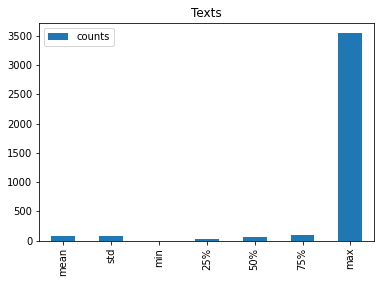

In [20]:
# Text analysing
lengths_texts = create_lengths(clean_texts)
print("Texts:")
print(lengths_texts.describe())
lengths_texts.describe()[1:].plot(kind="bar", title="Texts");

Summaries:
              counts
count  568427.000000
mean        4.181613
std         2.657912
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        48.000000


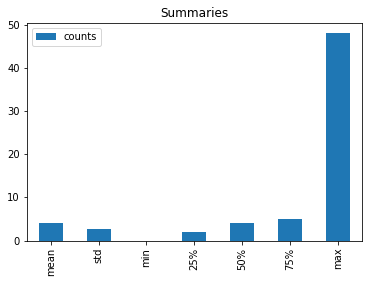

In [21]:
# Summary analysing
lengths_summaries = create_lengths(clean_summaries)
print("Summaries:")
print(lengths_summaries.describe())
lengths_summaries.describe()[1:].plot(kind="bar", title="Summaries");

In [22]:
def convert_to_ints(text, word_count, unk_count, summary, max_length):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        if summary:
            sentence_ints.append(vocab_to_int["<START>"])
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1


        while not summary and len(sentence_ints) < max_length:
            sentence_ints.append(vocab_to_int["<PAD>"])
        
        if summary and len(sentence_ints) >= max_length:
            sentence_ints[max_length-1] = vocab_to_int["<EOS>"]
        else:
            sentence_ints.append(vocab_to_int["<EOS>"])
        
        while summary and len(sentence_ints) < max_length:
            sentence_ints.append(vocab_to_int["<PAD>"])

        sentence_ints = sentence_ints[:max_length]
        ints.append(np.array(sentence_ints))

    return np.array(ints), word_count, unk_count

In [23]:
latent_dim = 50
max_len_text= 100
max_len_summary= 10

# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, False, max_len_text)
int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count, True, max_len_summary)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 48416640
Total number of UNKs in headlines: 131444
Percent of words that are UNK: 0.27%


In [24]:
int_texts[0]

array([  106,   473,  1229,  2714,    41,    17, 10304,  1345,     2,
           3,  2118,    44,   473,   847,   631,    10,    86,   368,
          41,     0,     1,    17,    62,   255,   117,   114,    80,
        3234,    36,    80,  1792,   904,    44,     9,  1143,    35,
          30,  6238,    74,  2972,    44,  1142,  9132,    33,    62,
          35,    36,  1102, 67650, 67650, 67650, 67650, 67650, 67650,
       67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650,
       67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650,
       67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650,
       67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650,
       67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650, 67650,
       67650])

In [25]:
int_summaries[0]

array([67651,     0,     1,     2,     3, 67652, 67650, 67650, 67650,
       67650])

In [26]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [27]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Texts:")
print(lengths_texts.describe())
print()
print("Summaries:")
print(lengths_summaries.describe())

Texts:
         counts
count  568427.0
mean      100.0
std         0.0
min       100.0
25%       100.0
50%       100.0
75%       100.0
max       100.0

Summaries:
         counts
count  568427.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0


In [28]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

### Train Test Data

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(int_texts, int_summaries, test_size=0.2, random_state=42)

### Model

In [30]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(len(word_embedding_matrix), latent_dim,trainable=True, weights=[word_embedding_matrix])(encoder_inputs) 

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb) 

#LSTM 2 
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
# encoder_output, state_h, state_c = encoder_lstm2(encoder_output1) 

# #LSTM 3 
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(len(word_embedding_matrix), latent_dim,trainable=True,  weights=[word_embedding_matrix]) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(len(word_embedding_matrix), activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      3382650     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     3382650     input_2[0][0]                    
______________________________________________________________________________________________

### Model Architecture

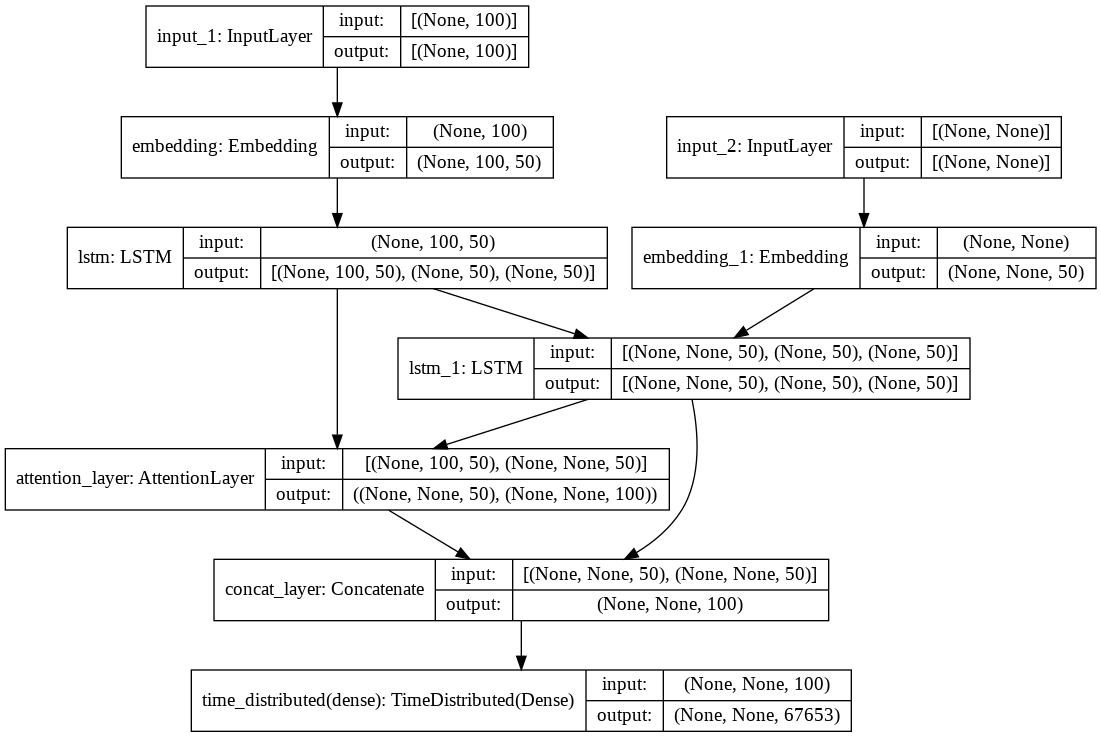

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [34]:
history=model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=512, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/5
889/889 [==============================] - 760s 817ms/step - loss: 4.5226 - val_loss: 2.8463
Epoch 2/5
889/889 [==============================] - 729s 820ms/step - loss: 2.7731 - val_loss: 2.5794
Epoch 3/5
889/889 [==============================] - 728s 819ms/step - loss: 2.5194 - val_loss: 2.3987
Epoch 4/5
889/889 [==============================] - 730s 821ms/step - loss: 2.3380 - val_loss: 2.2779
Epoch 5/5
889/889 [==============================] - 730s 821ms/step - loss: 2.2165 - val_loss: 2.1969


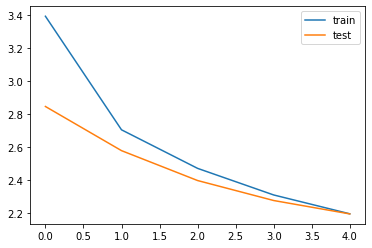

In [35]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [36]:
model.save_weights('weights.h5')

In [ ]:
model.save("model/summarizer")

### Encoder and Decoder

In [37]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Choose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = vocab_to_int['<START>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])

        # Sample a token
        #print(output_tokens)
        #print(output_tokens[0, -1, :])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = int_to_vocab[sampled_token_index]

        if (sampled_token!='<EOS>'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<EOS>' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=vocab_to_int['<START>']) and i!=vocab_to_int['<EOS>']):
        newString=newString+int_to_vocab[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+int_to_vocab[i]+' '
    return newString

### Predicted Samples

In [40]:
for i in range(0,5):
    print(i+1,"Review:",seq2text(X_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_len_text)))
    print("\n")

1 Review: these are actually very tasty pure potatoes with a great texture and no nasty filler stuff no bacon no cheese just tasty potatoes they cook well in either the oven or microwave i add a touch of either salt pepper or fajita seasoning to spice it up i rated 4 out of 5 stars because they could be a bit bigger portion however this item is a fairly value for the money <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Original summary: i like these <PAD> <PAD> <PAD> <PAD> <PAD> 
Predicted summary:  good stuff


2 Review: i realize that taste is a matter of personal preference so food reviews are always going to be hit or miss for your tastes got the cookies liked them but they did not quite send me the way other folks seem to take to them not bad and i do not feel i wasted my money but i will probably look for something else next time i am ordering snacks for work <PAD> 

### Rouge scores

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

hypothesis = "best chips ever"
reference = "spicy thai chips"

rouge = Rouge()
rouge.get_scores(hypothesis, reference)

[{'rouge-1': {'f': 0.3333333283333334,
   'p': 0.3333333333333333,
   'r': 0.3333333333333333},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.3333333283333334,
   'p': 0.3333333333333333,
   'r': 0.3333333333333333}}]

In [46]:
!python3 prepare.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Texts are complete.
Summaries are complete.
Size of Vocabulary: 136166
Word embeddings: 400000
136170
Texts:
              counts
count  568427.000000
mean       82.847787
std        82.597474
min         3.000000
25%        34.000000
50%        58.000000
75%       101.000000
max      3540.000000
Summaries:
              counts
count  568427.000000
mean        4.181613
std         2.657912
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        48.000000
Train Size : 454741
Test Size : 113686
Data preparation finished...


In [44]:
!python3 train.py

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      6808500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     6808500     input_2[0][0]                    
______________________________________________________________________________________________

In [45]:
!python3 generate.py

1 Review: these are actually very tasty pure potatoes with a great texture and no nasty filler stuff no bacon no cheese just tasty potatoes they cook well in either the oven or microwave i add a touch of either salt pepper or fajita seasoning to spice it up i rated 4 out of 5 stars because they could be a bit bigger portion however this item is a fairly value for the money <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Original summary: i like these <PAD> <PAD> <PAD> <PAD> <PAD> 
Predicted summary:  great product


2 Review: i realize that taste is a matter of personal preference so food reviews are always going to be hit or miss for your tastes got the cookies liked them but they did not quite send me the way other folks seem to take to them not bad and i do not feel i wasted my money but i will probably look for something else next time i am ordering snacks for work <PA